### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.stem import PorterStemmer

import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

### Loading Data

Load the data, and have a glimpse of the data

In [2]:
data = pd.read_csv('Suicide_Detection.csv')

print(data.head(),"\n")
print(data.info(),"\n")
print("Shape: ",data.shape)

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
None 

Shape:  (232074, 3)


The column 'Unnammed: 0' is a meaningless column at here, thus we can delete it

In [3]:
data.drop(columns = 'Unnamed: 0', inplace=True)
data.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


Check is null value available

In [4]:
data.isnull().sum()

text     0
class    0
dtype: int64

### Data Visualization

suicide        116037
non-suicide    116037
Name: class, dtype: int64


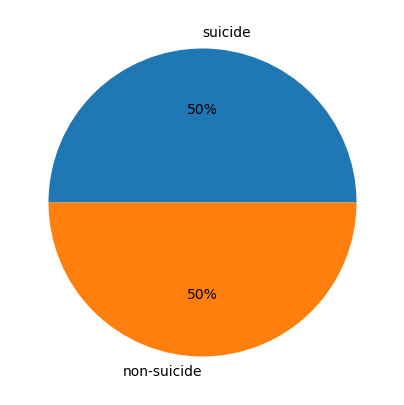

In [5]:
classCount = data["class"].value_counts()
print(classCount)

plt.figure(figsize=((20,5)))

plt.subplot(1,2,2)
plt.pie(classCount,labels = classCount.index,autopct='%.0f%%')

plt.show()


### Text Processing

In [6]:
# Convert texts to lower case
data['text'] = data['text'].str.lower()

# Remove punctuations
data['text'] = data['text'].str.replace(r'[^\w\s]+','',regex=True)

# Remove stop words
from nltk.corpus import stopwords
# nltk.download('stopwords')

stop_words = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Tokenize the words
data['text'] = data['text'].apply(lambda x:nltk.word_tokenize(x))

In [7]:
# Stemming the words
ps = PorterStemmer()
data['text'] = data['text'].apply(lambda x: [ps.stem(i) for i in x])
data['text'] = data['text'].apply(lambda x: ' '.join(x))

In [8]:
data.head()

,text,class
0,ex wife threaten suiciderec left wife good che...,suicide
1,weird dont get affect compliment come someon k...,non-suicide
2,final 2020 almost never hear 2020 bad year eve...,non-suicide
3,need helpjust help im cri hard,suicide
4,im losthello name adam 16 ive struggl year im ...,suicide


### Naive Bayes Classifier

In [24]:
import random
import pickle
import os

df = data['class']

def depression_words_list(depression_words):
    depression_list = []
    
    for df in depression_words.categories():
        for file_id in depression_words.fileids(df):
            depression_list.append((list(depression_words.text(file_id)),df))
    return depression_list

docs = depression_words_list(data)

x,y = data['text'],data['class']

fd = nltk.FreqDist(x)
top_keys = [key for (key,value) in fd.most_common(1000)]
print(top_keys[:10])

def review_features(doc):
    docSet = set(doc)
    features = {}
    
    for word in topKeys:
        features[word] = (word in docSet)
        
    return features
    
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['class'],test_size=0.30,random_state=5)
X_train.shape, y_train.shape

AttributeError: 'DataFrame' object has no attribute 'categories'

### Making Predictions

In [14]:
bayes = nltk.NaiveBayesClassifier.train(X_train)

# print(nltk.classifier.accuracy(bayes,X_train))

ValueError: too many values to unpack (expected 2)

### Conclusion